## import modules

In [1]:
import random
import os 
import numpy as np 
import tensorflow as tf
# Set a random seed for reproducibility
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
import pandas as pd 
from transformers import AutoTokenizer, TFAutoModel
import pandas as pd 
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

2023-11-29 11:34:32.653511: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [36]:
## Load data 

synthetic_user_data = pd.read_csv("/Users/nyzy/Library/CloudStorage/GoogleDrive-nitinmali999@gmail.com/.shortcut-targets-by-id/1yEbTjc1DwwTDd2CB86Il6F-3DhFUn8pU/Data Mining/data/processed_datasets/synthetic_data_cleaned_v5.csv")
import ast 
df = synthetic_user_data.copy()
# Fill missing values if necessary
df.fillna({'Course Taken': 'no course','course title': 'no course'}, inplace=True)
df["Course Taken"]=df["Course Taken"].apply(lambda x:x.replace("NAN","No Course"))

#df["Course Skills"]=df["Course Skills"].apply(lambda x:ast.literal_eval(x))
df["Course Skills"].apply(lambda x: x if len(x)!=0 else "no skills")
#df["Course title"]=df["Course title"].apply(lambda x:x.replace("NAN","No Course"))
def set_to_string(skill_set):
    if not skill_set:  # Checks if the set is empty
        return 'no skills' 
    # Check if skill_set is a string that needs to be evaluated
    if isinstance(skill_set, str):
        try:
            # Try to evaluate the string as a set
            skill_set = ast.literal_eval(skill_set)
        except (ValueError, SyntaxError):
            # Handle cases where the string is not a valid set
            pass  # You might want to return a default value or handle this case as needed
    # Convert to string if it's a set or list
    if isinstance(skill_set, (set, list)):
        return ', '.join(skill_set)
    return skill_set 

set_columns = ['Current Skills', 'Next Skills', 'Skill Gap', 'Course Skills']
for col in set_columns:
    print(col)
    #df[col]=df[col].apply(lambda x:ast.literal_eval(x))
    df[col] = df[col].apply(set_to_string)





#df = pd.read_csv("/Users/nyzy/Library/CloudStorage/GoogleDrive-nitinmali999@gmail.com/.shortcut-targets-by-id/1yEbTjc1DwwTDd2CB86Il6F-3DhFUn8pU/Data Mining/data/processed_datasets/df_embedding_bert.csv")

# Loading the JSON file back into a dictionary
import json
Job_progression_dictionary_file_path = "/Users/nyzy/Library/CloudStorage/GoogleDrive-nitinmali999@gmail.com/.shortcut-targets-by-id/1yEbTjc1DwwTDd2CB86Il6F-3DhFUn8pU/Data Mining/data/processed_datasets/job_progression_dictionary.json"

with open(Job_progression_dictionary_file_path, 'r') as json_file:
    sorted_full_job_progression_dict_lower = json.load(json_file)

#print(sorted_full_job_progression_dict_lower)
# Output: {'name': 'John', 'age': 30, 'city': 'New York'}




Current Skills
Next Skills
Skill Gap
Course Skills


In [3]:
df

,Unnamed: 0,Current Job,Next Job,Current Skills,Next Skills,Skill Gap,Current Min Salary,Current Max Salary,course title,Course Taken,Course Skills,top_10_course_numbers,top_10_course_score,random next job
0,0,director of product management,chief product officer,c,"problem solving, application design, analytics...","problem solving, application design, analytics...",1.250301,1.234592,complete data science project management course,data mining,"python, project management, data science, data...","[615, 974, 1542, 968, 2953, 323, 1437, 1240, 2...","{615: 0.311, 974: 0.28, 1542: 0.266, 968: 0.26...",0
1,1,business analyst,senior business analyst,"java, sql","product lifecycle management, technology solut...","product lifecycle management, technology solut...",-0.542432,-0.320986,avaya ip office server,artificial intelligence,artificial intelligence,"[701, 1542, 1745, 1992, 1434, 1182, 1471, 1124...","{701: 0.212, 1542: 0.165, 1745: 0.165, 1992: 0...",0
2,2,data product manager,senior data product manager,"analytics, project management, business analys...","quantitative analysis, sql, machine learning, ...","sql, quantitative analysis, computer science, ...",-0.413977,-0.415478,data analyst python beginners,undefined,"python, statistical analysis, data analysis, d...","[1670, 1478, 1520, 2036, 892, 904, 788, 1763, ...","{1670: 0.354, 1478: 0.329, 1520: 0.295, 2036: ...",0
3,3,senior data analyst,data engineer,"bigquery, python, sql, airflow, problem solvin...","data processing, sql, apache kafka, data wareh...","data processing, data warehousing, computer sc...",0.116418,0.110388,f rdan apache kafka z kurulum kullan java python,apache kafka,"python, java, apache kafka","[2563, 2135, 2525, 323, 2036, 1991, 1542, 1520...","{2563: 0.409, 2135: 0.285, 2525: 0.264, 323: 0...",0
4,4,database administrator,senior database administrator,"data modeling, sql, data quality, pl sql, java...","technology solutions, sql, computer science, d...","technology solutions, computer science, databa...",-1.320774,-1.404756,postgresql database administration masterclass,database administration,"database design, database administration, data...","[1783, 1233, 109, 49, 1124, 1292, 1592, 1998, ...","{1783: 0.584, 1233: 0.206, 109: 0.185, 49: 0.1...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34253,8055,chief product officer,big data engineer,"product lifecycle management, analytics, data ...","data ingestion, data transformation, data pipe...","data processing, data ingestion, data warehous...",0.132992,0.126822,apache spark hands specialization big data ana...,apache spark,"python, amazon, analytics, apache spark, datab...","[303, 1991, 1503, 1728, 1634, 1722, 904, 927, ...","{303: 0.425, 1991: 0.4, 1503: 0.391, 1728: 0.3...",0
34254,8056,data architect,data manager,"data warehousing, computer science, data archi...","technology solutions, python, computer science...","technology solutions, data analysis, data mana...",0.609519,0.599280,getting started data management,database management,"python, sql, database design, data quality, da...","[323, 1542, 1670, 446, 755, 444, 1645, 1091, 1...","{323: 0.401, 1542: 0.366, 1670: 0.345, 446: 0....",0
34255,8057,machine learning manager,chief technology officer,"llm, data pipelines, artificial intelligence, ...","computer science, analytics, machine learning,...",big data,0.380981,0.349892,big data programming languages big data vs dat...,big data,"data science, big data","[289, 841, 1043, 1119, 1690, 1526, 680, 1520, ...","{289: 0.796, 841: 0.66, 1043: 0.64, 1119: 0.50...",1
34256,8058,data science manager,director of data science,"cloud computing, sql, python, problem solving,...","sql, ad hoc analysis, data quality, data gover...","ad hoc analysis, data quality, data governance...",0.634381,0.623930,predictive analytics model term deposit invest...,undefined,"predictive analytics, data analysis, statistic...","[1957, 1922, 1971, 1861, 323, 961, 1395, 792, ...","{1957: 0.342, 1922: 0.331, 1971:

In [37]:
df = df.drop(columns=[ 'Unnamed: 0'])
#df = df[df["random next job"]!=1].drop_duplicates()

In [13]:
df.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['Current Job', 'Next Job', 'Current Skills', 'Next Skills', 'Skill Gap',
       'Current Min Salary', 'Current Max Salary', 'course title',
       'Course Taken', 'Course Skills', 'top_10_course_numbers',
       'top_10_course_score', 'random next job'],
      dtype='object')>

In [38]:
ts_d = df[['Current Job', 'Next Job', 'Current Skills']].drop_duplicates()
ts_d

,Current Job,Next Job,Current Skills
0,director of product management,chief product officer,c
1,business analyst,senior business analyst,"java, sql"
2,data product manager,senior data product manager,"analytics, project management, business analys..."
3,senior data analyst,data engineer,"bigquery, python, sql, airflow, problem solvin..."
4,database administrator,senior database administrator,"data modeling, sql, data quality, pl sql, java..."
...,...,...,...
34164,director of business intelligence,chief information officer,"power bi, data modeling, data warehousing, mac..."
34176,quantitative research manager,senior data architect,"project management, business analysis, statist..."
34177,machine learning manager,senior business analyst,"devops, computer science, computer vision, dat..."
34194,director of business intelligence,data engineer,"database queries, power bi, sql, computer scie..."


In [6]:
## Build embedding 


# Initialize tokenizer and model from Hugging Face
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = TFAutoModel.from_pretrained("bert-base-uncased")

def get_embedding(text):
    inputs = tokenizer(text, return_tensors="tf", padding=True, truncation=True, max_length=512)
    outputs = model(inputs)
    return tf.reduce_mean(outputs.last_hidden_state, 1).numpy()[0]  # Mean pooling

'''
text_columns = ['Current Job', 'Next Job', 'Current Skills', 'Next Skills', 'Skill Gap', 'course title', 'Course Skills', 'Course Taken']
for col in text_columns:
    df[f'{col}_embedding'] = df[col].apply(get_embedding)
'''

unique_job_titles=set()
for key,value in sorted_full_job_progression_dict_lower.items():
    unique_job_titles.add(key)
    for each in value:
        unique_job_titles.add(each)
unique_job_titles

job_embeddings = {}
for job in unique_job_titles:
    embedding = get_embedding(job)  # Using the same function as in your model
    job_embeddings[tuple(embedding)] = job  # Storing embedding as tuple for dictionary key


2023-11-29 11:35:45.186217: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model tha

In [39]:
def batch_encode(texts, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="tf", padding=True, truncation=True, max_length=512)
        outputs = model(inputs)
        batch_embeddings = tf.reduce_mean(outputs.last_hidden_state, 1).numpy()
        embeddings.extend(batch_embeddings)
    return embeddings
#text_columns = ['Current Job', 'Next Job', 'Current Skills', 'Next Skills', 'Skill Gap', 'course title', 'Course Skills', 'Course Taken']
text_columns = ['Current Job', 'Next Job', 'Current Skills']
embeddings_dict = {}
for col in text_columns:
    embeddings_dict[col] = batch_encode(ts_d[col].tolist())

np.savez_compressed('/Users/nyzy/Library/CloudStorage/GoogleDrive-nitinmali999@gmail.com/.shortcut-targets-by-id/1yEbTjc1DwwTDd2CB86Il6F-3DhFUn8pU/Data Mining/data/processed_datasets/all_embeddings_job_only.npz', **embeddings_dict)
loaded_embeddings = np.load('/Users/nyzy/Library/CloudStorage/GoogleDrive-nitinmali999@gmail.com/.shortcut-targets-by-id/1yEbTjc1DwwTDd2CB86Il6F-3DhFUn8pU/Data Mining/data/processed_datasets/all_embeddings_job_only.npz')


In [40]:
#'Next Skills', 'Skill Gap', 'course title', 'Course Skills'
feature_columns = ['Current Job', 'Current Skills',]
# Stack embeddings horizontally (axis=1)
all_embeddings = np.hstack((loaded_embeddings[each] for each in feature_columns)) # Add other embeddings as needed
y_job = loaded_embeddings['Next Job']
#y_course = loaded_embeddings['Course Taken_embedding']

from sklearn.model_selection import train_test_split

# Assuming 'target' is your target array
X_train, X_test, y_job_train, y_job_test = train_test_split(all_embeddings, y_job, test_size=0.1, random_state=42)

# Flatten the embeddings if they are not already
X_train_flat = X_train.reshape(X_train.shape[0],len(feature_columns), -1)
X_test_flat = X_test.reshape(X_test.shape[0],len(feature_columns), -1)

# Verify the new shapes
print("X_train_flat shape:", X_train_flat.shape)
print("X_test_flat shape:", X_test_flat.shape)
X_train_tensor = tf.convert_to_tensor(X_train_flat, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test_flat, dtype=tf.float32)

print("X_train_tensor shape:", X_train_tensor.shape)
print("X_test_tensor shape:", X_test_tensor.shape)


y_job_train_tensor = tf.convert_to_tensor(y_job_train, dtype=tf.float32)
y_job_test_tensor = tf.convert_to_tensor(y_job_test, dtype=tf.float32)

print("Y_job_train_tensor shape:", y_job_train_tensor.shape)
print("Y_job_test_tensor shape:", y_job_test_tensor.shape)


/var/folders/17/gws30jys63j9xx5l0mwr5r4r0000gq/T/ipykernel_40027/3892250985.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  all_embeddings = np.hstack((loaded_embeddings[each] for each in feature_columns)) # Add other embeddings as needed


X_train_flat shape: (3809, 2, 768)
X_test_flat shape: (424, 2, 768)
X_train_tensor shape: (3809, 2, 768)
X_test_tensor shape: (424, 2, 768)
Y_job_train_tensor shape: (3809, 768)
Y_job_test_tensor shape: (424, 768)


In [41]:
## Attention layer 



class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', 
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # e = K.tanh(K.dot(x, self.W) + self.b)
        e = K.squeeze(K.tanh(K.dot(x, self.W) + self.b), axis=-1)
        a = K.softmax(e)
        a = K.expand_dims(a, axis=-1)
        weighted_output = x * a
        return K.sum(weighted_output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])


In [42]:
## Build model architecture 

'''
model_job = Sequential()

# Add the first LSTM layer with input_shape
model_job.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(6, 768)))

# Add dropout for regularization
model_job.add(Dropout(0.2))

# Add the second LSTM layer
# No need to specify input_shape as it's not the first layer of the model
model_job.add(Bidirectional(LSTM(128)))

# Another dropout layer
model_job.add(Dropout(0.2))


# Final Dense layer to output the embeddings
model_job.add(Dense(768))  # Make sure this matches the size of your embeddings
'''
'''
model_job = Sequential()

# First LSTM layer
model_job.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(6, 768)))
model_job.add(Dropout(0.2))

# Additional LSTM layer, with return_sequences=True since there's another LSTM layer following
model_job.add(Bidirectional(LSTM(128, return_sequences=True)))
model_job.add(Dropout(0.2))

# Last LSTM layer, return_sequences is False by default
model_job.add(Bidirectional(LSTM(128)))
model_job.add(Dropout(0.2))

# Dense layers can also be added for further processing
model_job.add(Dense(256, activation='relu'))
model_job.add(Dropout(0.2))

# Output layer
model_job.add(Dense(768))  
'''

model_job = Sequential()

# First LSTM layer
model_job.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(len(feature_columns), 768)))
model_job.add(Dropout(0.2))

# Second LSTM layer
model_job.add(Bidirectional(LSTM(128, return_sequences=True)))
model_job.add(Dropout(0.2))

# Attention Layer
model_job.add(AttentionLayer())

# Dense layer (optional, depending on your specific problem)
model_job.add(Dense(256, activation='relu'))
model_job.add(Dropout(0.2))

# Output layer
model_job.add(Dense(768))  




model_job.compile(optimizer='Adam', loss='mean_squared_error')
history = model_job.fit(X_train_tensor, y_job_train_tensor, epochs=10, batch_size=32, validation_split=0.2)
loss = model_job.evaluate(X_test_tensor, y_job_test_tensor)
print(f"Test Loss: {loss}")

#Make Predictions
predictions = model_job.predict(X_test_tensor)


Epoch 1/10
96/96 [==============================] - 14s 48ms/step - loss: 0.0364 - val_loss: 0.0247
Epoch 2/10
96/96 [==============================] - 2s 26ms/step - loss: 0.0248 - val_loss: 0.0210
Epoch 3/10
96/96 [==============================] - 2s 24ms/step - loss: 0.0202 - val_loss: 0.0174
Epoch 4/10
96/96 [==============================] - 3s 26ms/step - loss: 0.0174 - val_loss: 0.0155
Epoch 5/10
96/96 [==============================] - 2s 25ms/step - loss: 0.0162 - val_loss: 0.0147
Epoch 6/10
96/96 [==============================] - 3s 28ms/step - loss: 0.0154 - val_loss: 0.0142
Epoch 7/10
96/96 [==============================] - 3s 27ms/step - loss: 0.0148 - val_loss: 0.0139
Epoch 8/10
96/96 [==============================] - 3s 28ms/step - loss: 0.0146 - val_loss: 0.0138
Epoch 9/10
96/96 [==============================] - 3s 28ms/step - loss: 0.0143 - val_loss: 0.0135
Epoch 10/10
14/14 [==============================] - 0s 6ms/step - loss: 0.0124
Test Loss: 0.012448218651115

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
def find_closest_job_title(prediction, embedding_dict):
    highest_similarity = -1
    closest_job = None

    # Ensure prediction is a 2D array
    if len(prediction.shape) == 1:
        prediction = prediction.reshape(1, -1)

    for ref_embedding_tuple, job_title in embedding_dict.items():
        # Convert tuple to NumPy array and reshape to 2D
        ref_embedding = np.array(ref_embedding_tuple).reshape(1, -1)

        similarity = cosine_similarity(prediction, ref_embedding)[0][0]
        if similarity > highest_similarity:
            highest_similarity = similarity
            closest_job = job_title

    return closest_job



predicted_job_titles = [find_closest_job_title(pred, job_embeddings) for pred in predictions]

actual_job_titles = [find_closest_job_title(actual_emb, job_embeddings) for actual_emb in y_job_test]
matches = [pred == actual for pred, actual in zip(predicted_job_titles, actual_job_titles)]
accuracy = sum(matches) / len(matches)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 51.89%


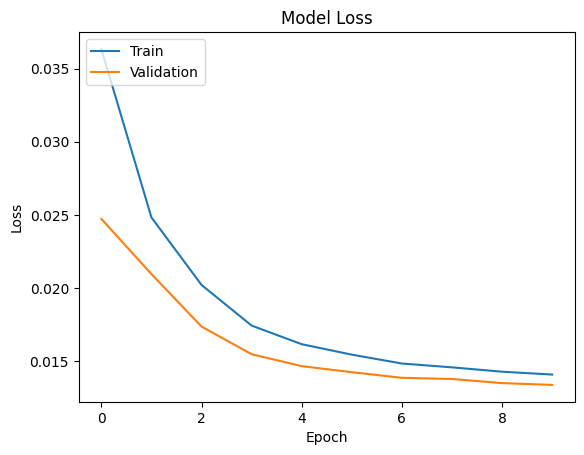

In [44]:
import matplotlib.pyplot as plt
# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
## Seq2Seq model 

